In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import image, plotting

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [15]:
#Fixing seed for reproducibility
np.random.seed(0) 

In [16]:
#Loading data
from nilearn import datasets
num = 40
adhd_data = datasets.fetch_adhd(n_subjects=num)

In [17]:
adhd_data.keys()

dict_keys(['func', 'confounds', 'phenotypic', 'description'])

In [18]:
len(adhd_data['func'])

40

In [19]:
#Getting the functional files
func = adhd_data.func
print(func[0])

/Users/gelanatostaeva/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz


In [20]:
#Using nilearn's individual component analysis for group level
from nilearn import decomposition

canica = decomposition.CanICA(n_components=20, mask_strategy='background')
canica.fit(func)


CanICA(detrend=True, do_cca=True, high_pass=None, low_pass=None, mask=None,
       mask_args=None, mask_strategy='background', memory=Memory(location=None),
       memory_level=0, n_components=20, n_init=10, n_jobs=1, random_state=None,
       smoothing_fwhm=6, standardize=True, t_r=None, target_affine=None,
       target_shape=None, threshold='auto', verbose=0)

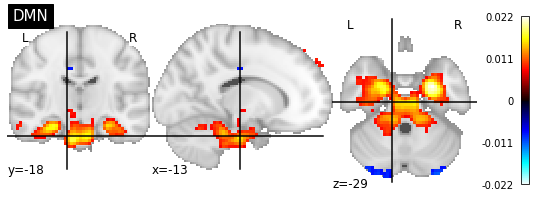

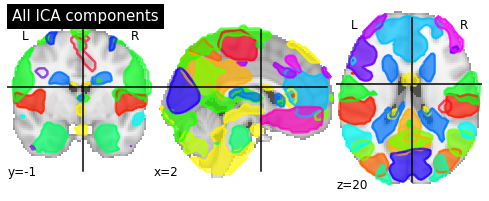

In [21]:
#Retrieving the components
components = canica.components_

#Using a masker to project into the 3D space
components_img = canica.masker_.inverse_transform(components)

#Plotting the default mode network (DMN) without region extraction
plotting.plot_stat_map(image.index_img(components_img, 9), title='DMN')
plotting.show()

#Plotting all the components
plotting.plot_prob_atlas(components_img, title='All ICA components')
plotting.show()

In [22]:
#Using a filter to extract the regions time series 
from nilearn import input_data
masker = input_data.NiftiMapsMasker(components_img, smoothing_fwhm=6,
                         standardize=False, detrend=True,
                         t_r=2.5, low_pass=0.1,
                         high_pass=0.01)



#Computing the regions signals and extracting the phenotypic information of interest
subjects = []
adhds = []
sites = []
labels = []
for func_file, confound_file, phenotypic in zip(
        adhd_data.func, adhd_data.confounds, adhd_data.phenotypic):
    time_series = masker.fit_transform(func_file, confounds=confound_file)
    subjects.append(time_series)
    is_adhd = phenotypic['adhd']
    if is_adhd == 1:
        adhds.append(time_series)    
    sites.append(phenotypic['site'])
    labels.append(phenotypic['adhd'])

In [24]:
#Comparing the three types of functional connectivity between the regions of interest
from nilearn.connectome import ConnectivityMeasure

connectivity_biomarkers = {}

kinds = ['correlation', 'partial correlation', 'tangent']
for kind in kinds:
    conn_measure = ConnectivityMeasure(kind=kind, vectorize=True)
    connectivity_biomarkers[kind] = conn_measure.fit_transform(subjects)

# For each kind, all individual coefficients are stacked in a unique 2D matrix.
print('{0} correlation biomarkers for each subject.'.format(
    connectivity_biomarkers['tangent'].shape[1]))

210 correlation biomarkers for each subject.


In [25]:
#Stratifying the data to use for comparison

from sklearn.model_selection import StratifiedKFold

classes = ['{0}{1}'.format(site_name, adhd_label)
           for site_name, adhd_label in zip(sites, labels)]
cv = StratifiedKFold(n_splits=3)

In [26]:
#Classifying using the connectivity coefficients and linear support vector
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

mean_scores = []
for kind in kinds:
    svc = LinearSVC(random_state=0)
    cv_scores = cross_val_score(svc,
                                connectivity_biomarkers[kind],
                                y=labels,
                                cv=cv,
                                groups=labels,
                                scoring='accuracy',
                                )
    mean_scores.append(cv_scores.mean())

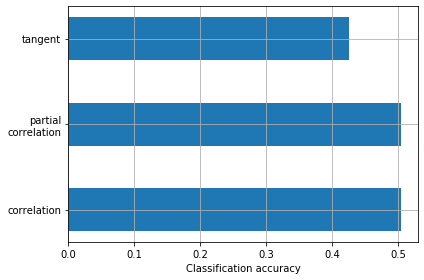

In [27]:
#Visualizing results and accuracy
from nilearn.plotting import show

plt.figure(figsize=(6, 4))
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05)
yticks = [kind.replace(' ', '\n') for kind in kinds]
plt.yticks(positions, yticks)
plt.xlabel('Classification accuracy')
plt.grid(True)
plt.tight_layout()

show()

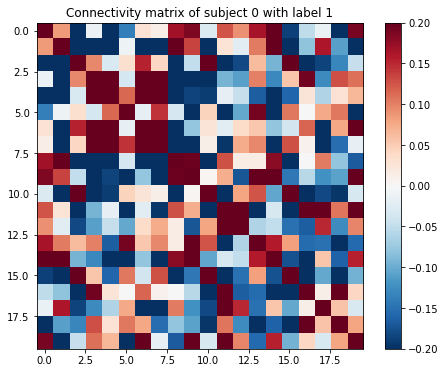

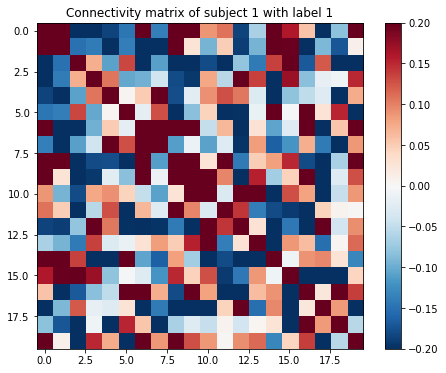

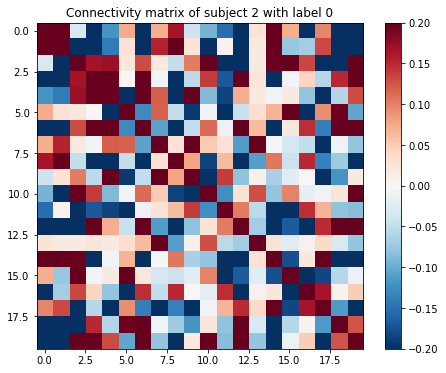

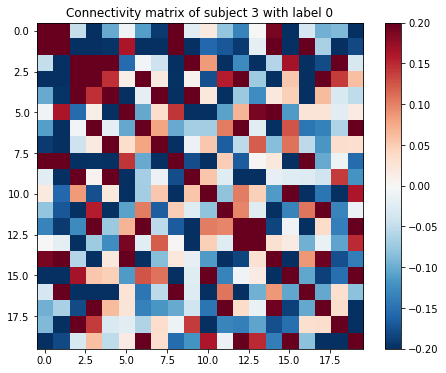

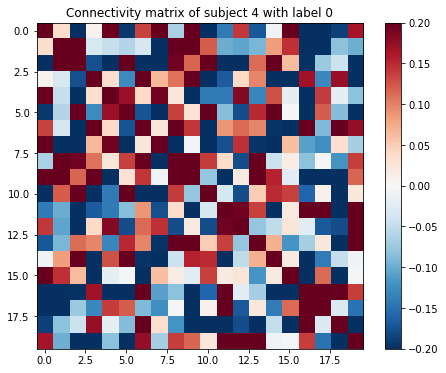

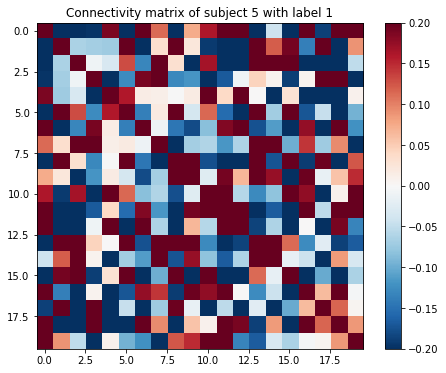

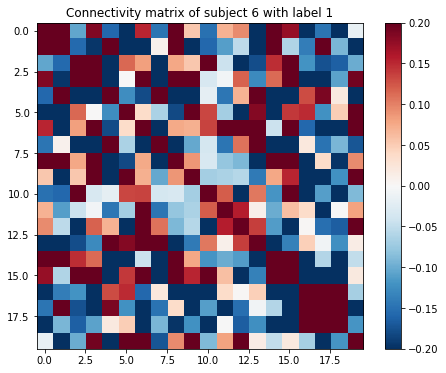

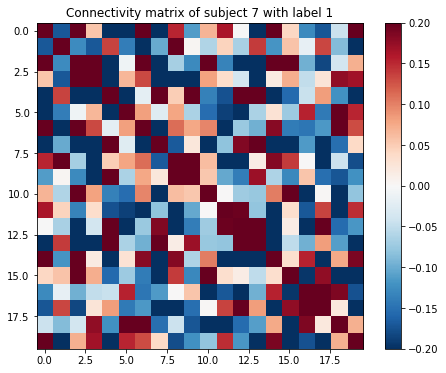

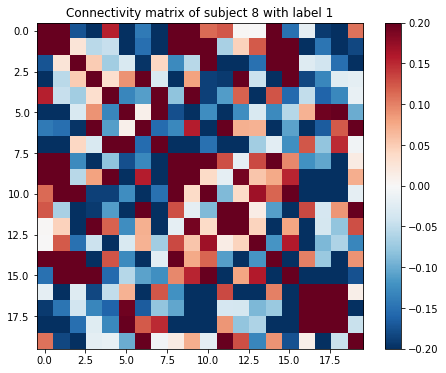

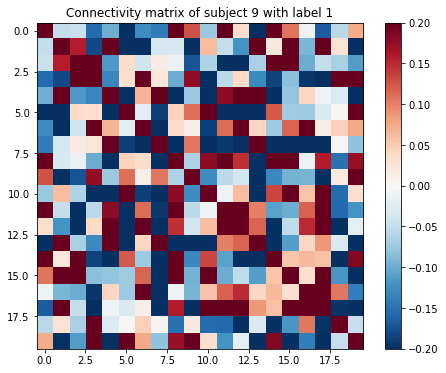

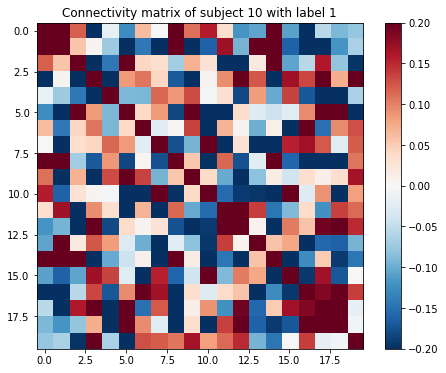

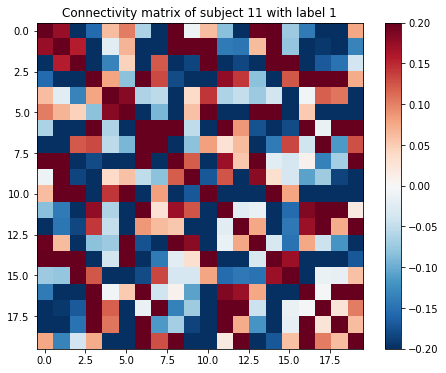

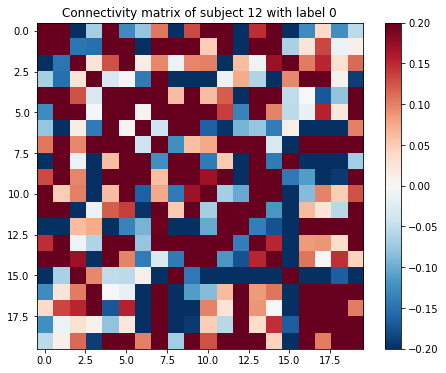

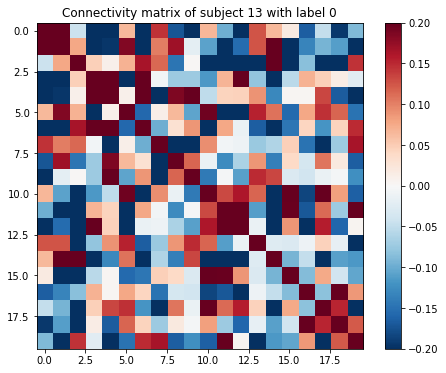

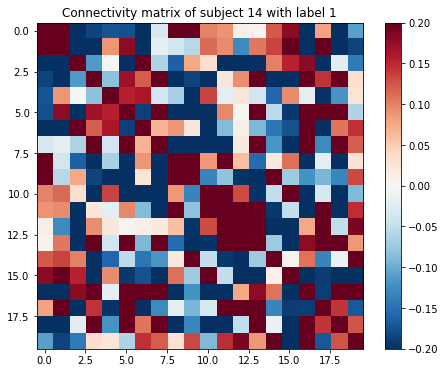

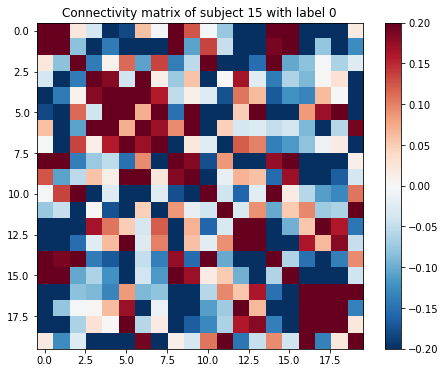

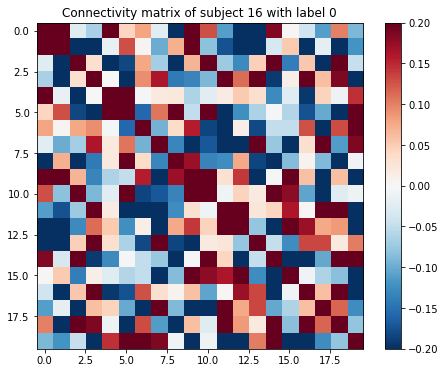

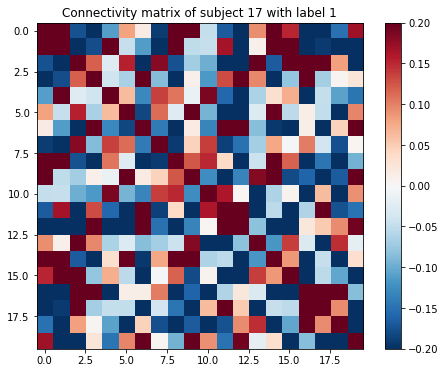

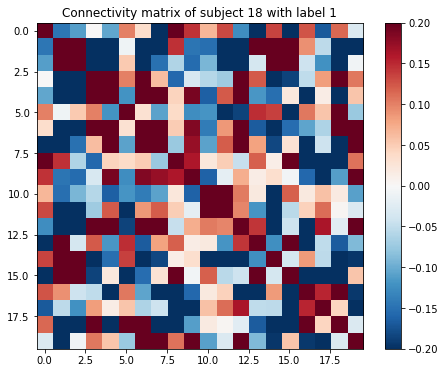

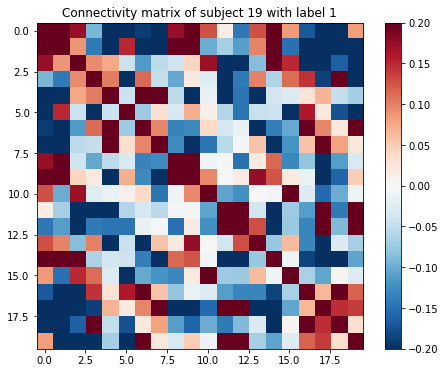

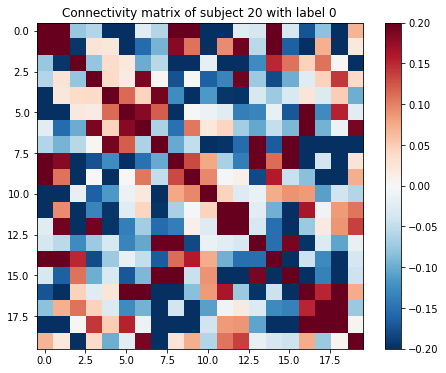

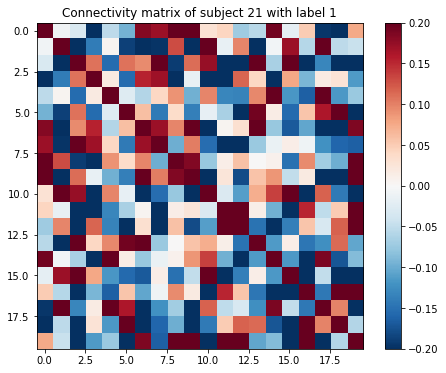

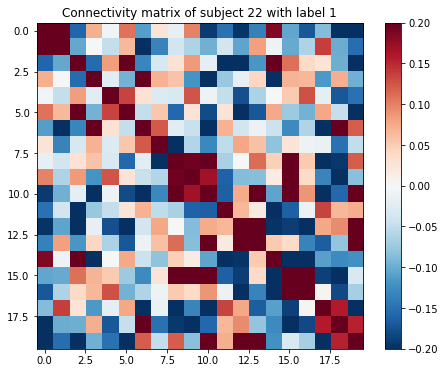

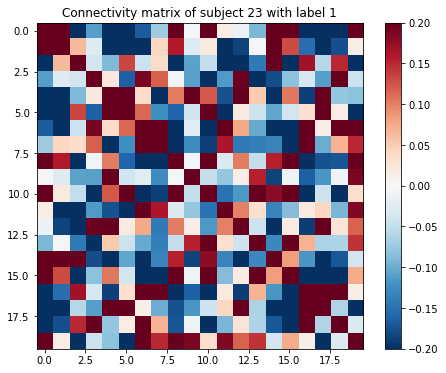

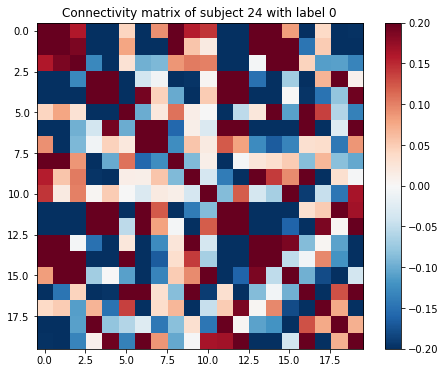

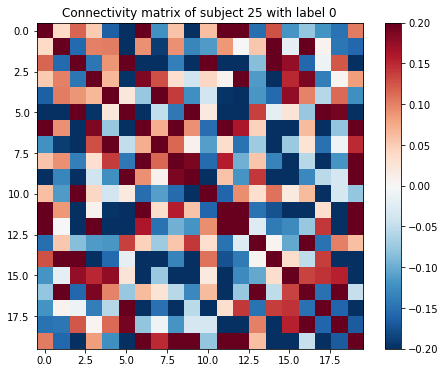

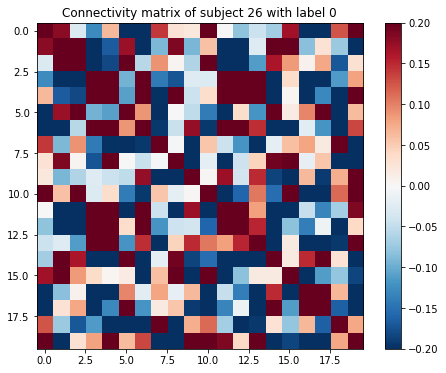

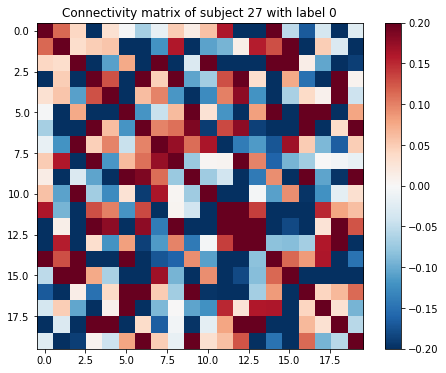

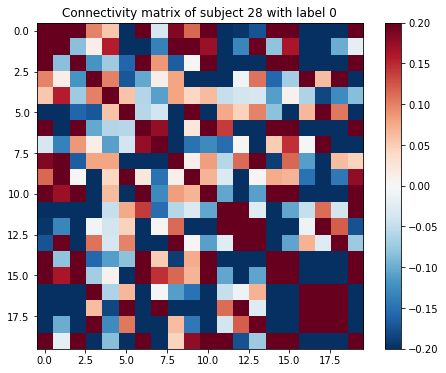

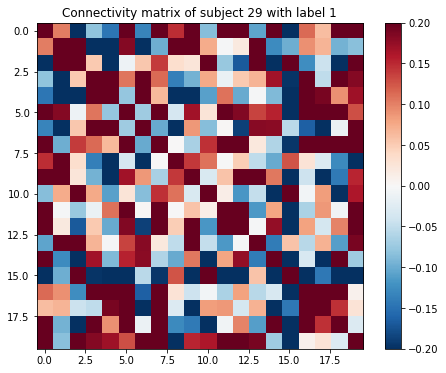

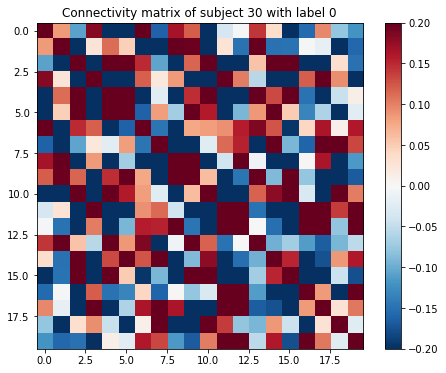

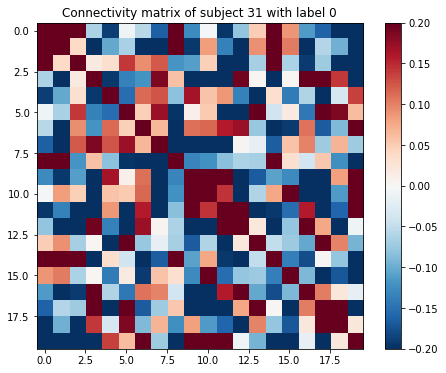

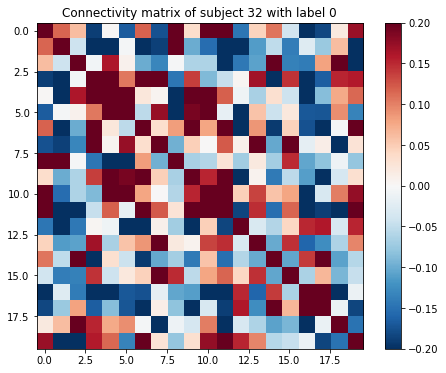

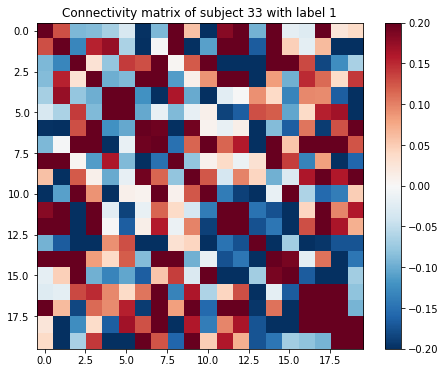

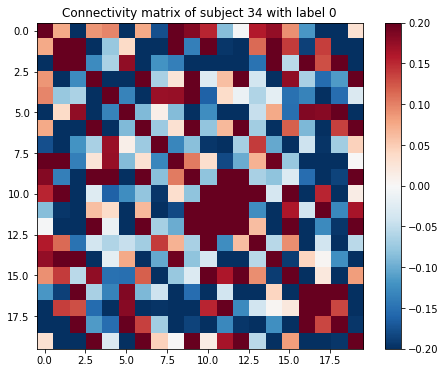

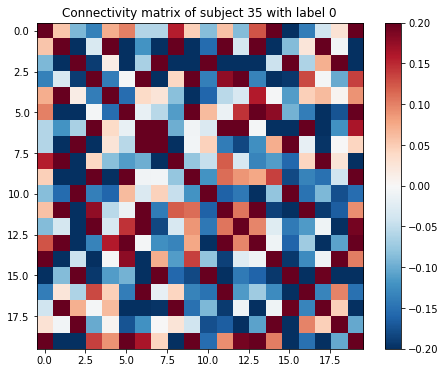

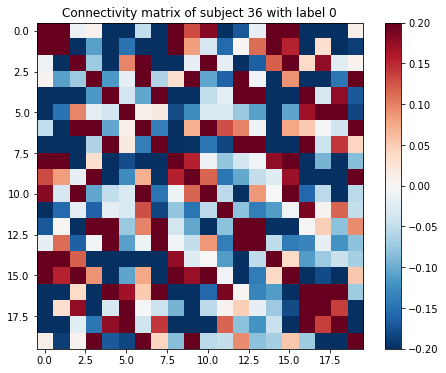

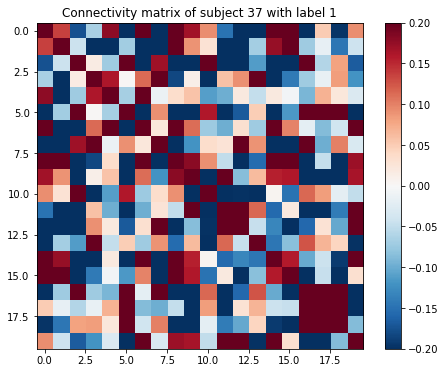

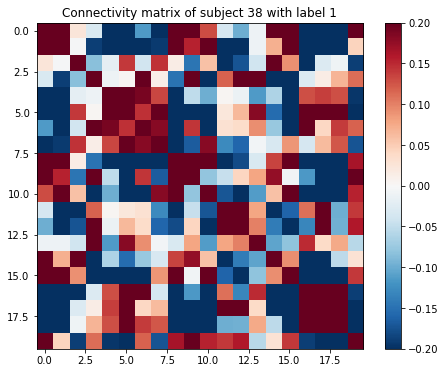

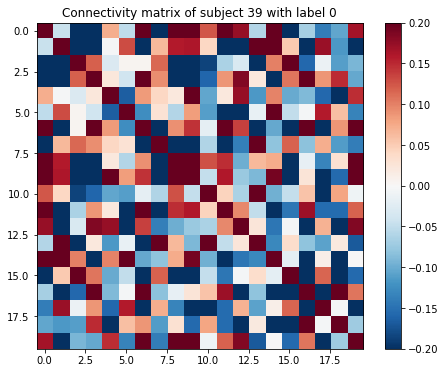

In [62]:
#Displaying the connectomes for the most accurate kind of functional connectivity
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = correlation_measure.fit_transform(subjects)

for i in range(40):
    plt.figure(figsize=(8,6))
    plt.imshow(correlation_matrices[i], vmax=.20, vmin=-.20, cmap='RdBu_r')
    plt.colorbar()
    plt.title('Connectivity matrix of subject {} with label {}'.format(i, labels[i]))

## Neural Networks Approach

In [51]:
#Splitting data into training and testing

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(connectivity_biomarkers['correlation'], labels, test_size=0.3)

In [57]:
#Creating the classification model
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(32, activation='tanh', kernel_initializer='random_normal', input_shape=connectivity_biomarkers['correlation'].shape[1:]))
#Second  Hidden Layer
classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
#Third  Hidden Layer
classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

In [58]:
#Compiling the model
classifier.compile(optimizer = Adam(lr =.0001),loss='binary_crossentropy', metrics =['accuracy'])

In [59]:
#Fitting the model
classifier.fit(np.array(X_train),np.array(y_train), batch_size=32, epochs=100)

Epoch 1/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4286
Epoch 2/100
28/28 [==============================] - 0s 74us/step - loss: 0.6932 - accuracy: 0.4286
Epoch 3/100
28/28 [==============================] - 0s 78us/step - loss: 0.6931 - accuracy: 0.4643
Epoch 4/100
28/28 [==============================] - 0s 56us/step - loss: 0.6931 - accuracy: 0.5357
Epoch 5/100
28/28 [==============================] - 0s 56us/step - loss: 0.6931 - accuracy: 0.5357
Epoch 6/100
28/28 [==============================] - 0s 67us/step - loss: 0.6931 - accuracy: 0.6071
Epoch 7/100
28/28 [==============================] - 0s 75us/step - loss: 0.6931 - accuracy: 0.5714
Epoch 8/100
28/28 [==============================] - 0s 94us/step - loss: 0.6931 - accuracy: 0.5714
Epoch 9/100
28/28 [==============================] - 0s 78us/step - loss: 0.6931 - accuracy: 0.6071
Epoch 10/100
28/28 [==============================] - 0s 91us/step - loss: 0.6931 - accuracy: 0.6786


In [60]:
#Determining accuracy on training
eval_model=classifier.evaluate(np.array(X_train), np.array(y_train))
eval_model

28/28 [==============================] - 0s 924us/step


[0.6917073130607605, 1.0]

In [61]:
#Making the classification and determining accuracy
y_pred=classifier.predict(X_test,batch_size=32)
y_pred =(y_pred>0.5)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)

[[4 2]
 [1 5]]
              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.71      0.83      0.77         6

    accuracy                           0.75        12
   macro avg       0.76      0.75      0.75        12
weighted avg       0.76      0.75      0.75        12

